a) Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


b) Import danych

In [2]:
df = pd.read_csv('cwiczenie8-dane.csv')
df.head()


,sex,age,bmi,systolic_bp,diastolic_bp,glucose,smoker,family_history,high_risk_cvd
0,M,81,31.7,109.0,84,110.0,no,no,1
1,F,22,21.5,105.0,65,98.0,no,yes,0
2,M,46,21.6,126.0,66,123.0,no,yes,1
3,M,50,28.3,110.0,66,87.0,no,no,0
4,F,75,31.7,119.0,89,123.0,yes,no,1


c) Identyfikacja problemu predykcyjnego

In [3]:
target = 'high_risk_cvd'
X = df.drop(columns=[target])
y = df[target]
y.value_counts()


high_risk_cvd
1    661
0    339
Name: count, dtype: int64

d) Przygotowanie danych

In [4]:
df.isna().sum()
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

preprocess = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])


e) Analiza eksploracyjna (EDA)

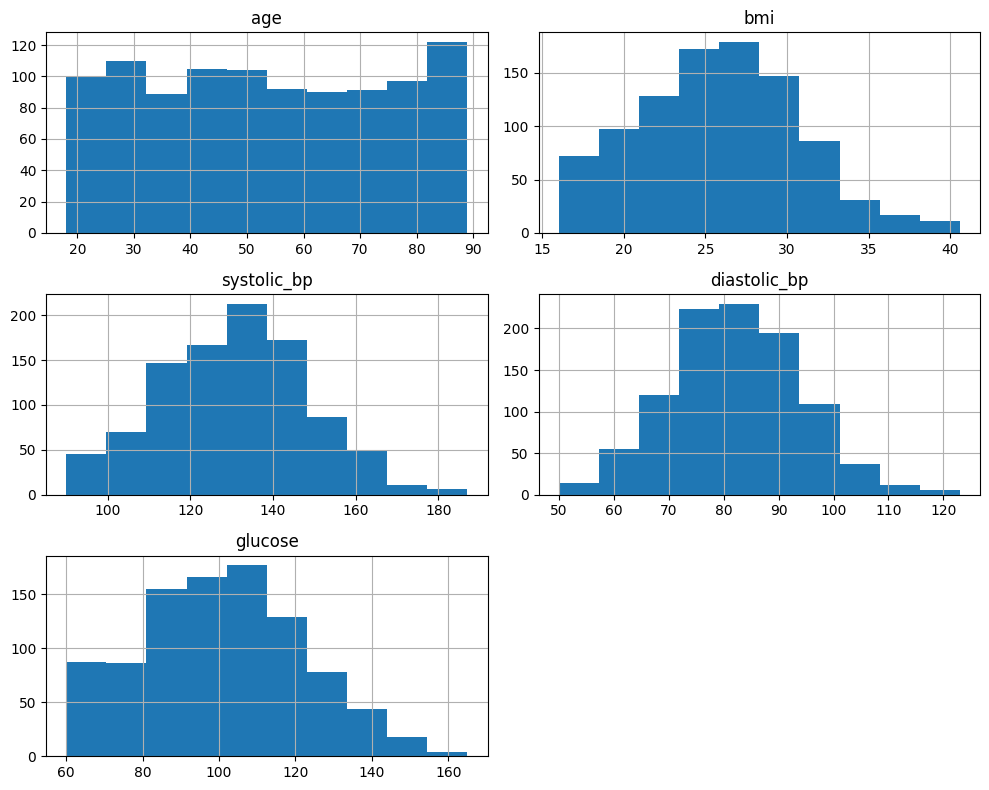

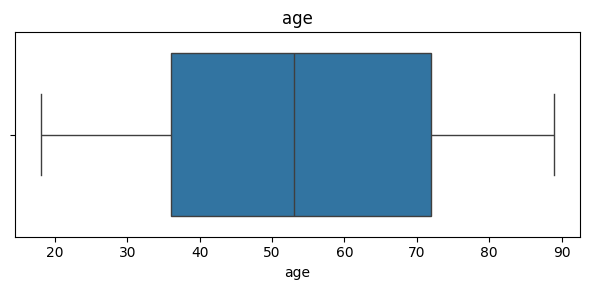

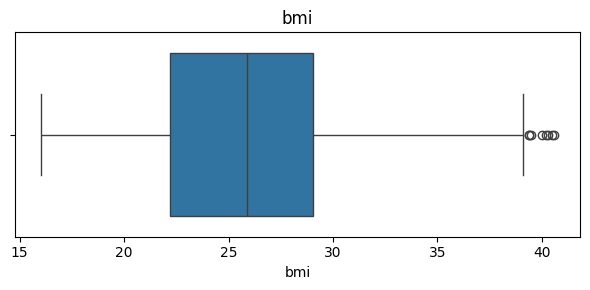

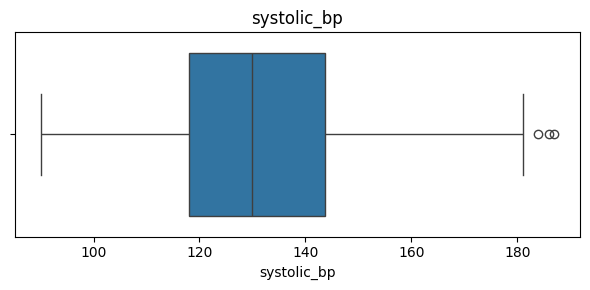

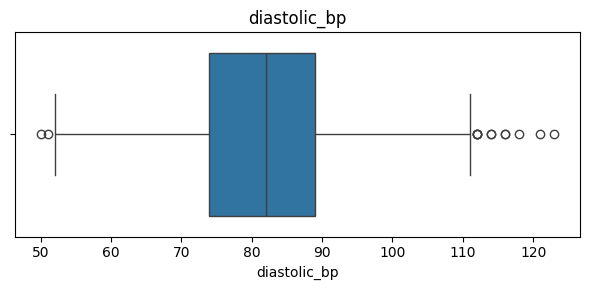

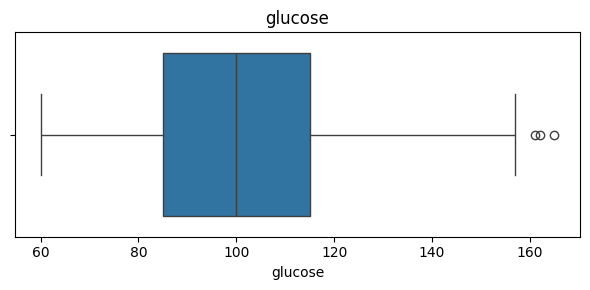

In [5]:
df.describe(include='all')

df[num_cols].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.tight_layout()
    plt.show()


f) Podzia? danych

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


g) Budowa modelu bazowego

In [7]:
log_reg = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'glucose'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['sex', 'smoker', 'family_history'], dtype='object'))])),
                ('clf', LogisticRegression(max_iter=1000))])

h) Ewaluacja modelu (pr?g domy?lny)

In [8]:
proba_lr = log_reg.predict_proba(X_test)[:, 1]
y_pred_lr = (proba_lr >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_lr)
acc = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr)
rec = recall_score(y_test, y_pred_lr)

cm, acc, prec, rec


(array([[ 42,  43],
        [ 23, 142]], dtype=int64),
 0.736,
 0.7675675675675676,
 0.8606060606060606)

i) Ewaluacja z progami decyzyjnymi

In [9]:
thresholds = [0.4, 0.5, 0.6]
rows = []
for t in thresholds:
    pred = (proba_lr >= t).astype(int)
    cm_t = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm_t.ravel()
    rows.append({'threshold': t, 'FN': fn, 'FP': fp, 'TP': tp, 'TN': tn})

pd.DataFrame(rows)


,threshold,FN,FP,TP,TN
0,0.4,17,58,148,27
1,0.5,23,43,142,42
2,0.6,33,25,132,60


j) Analiza b??d?w klinicznych

In [10]:
test_results = X_test.copy()
test_results['y_true'] = y_test
test_results['proba'] = proba_lr
test_results['y_pred'] = y_pred_lr

fn_cases = test_results[(test_results['y_true'] == 1) & (test_results['y_pred'] == 0)].head(3)
fp_cases = test_results[(test_results['y_true'] == 0) & (test_results['y_pred'] == 1)].head(3)

fn_cases, fp_cases


(    sex  age   bmi  systolic_bp  diastolic_bp  glucose smoker family_history  \
 31    M   30  25.3        117.0            71     80.0     no             no   
 128   F   22  20.2          NaN            72     62.0    yes             no   
 393   M   33  28.9        136.0            78     62.0     no             no   
 
      y_true     proba  y_pred  
 31        1  0.244991       0  
 128       1  0.153438       0  
 393       1  0.362119       0  ,
     sex  age   bmi  systolic_bp  diastolic_bp  glucose smoker family_history  \
 619   F   86  22.5        148.0            76      NaN    yes            yes   
 670   F   75  27.2        143.0            95     80.0     no             no   
 731   F   55  21.5        114.0            91    111.0     no            yes   
 
      y_true     proba  y_pred  
 619       0  0.934282       1  
 670       0  0.800378       1  
 731       0  0.596400       1  )

k) Drugi model predykcyjny

In [11]:
rf = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'glucose'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['sex', 'smoker', 'family_history'], dtype='object'))])),
                ('clf',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

l) Por?wnanie modeli

In [12]:
proba_rf = rf.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, proba_lr)
auc_rf = roc_auc_score(y_test, proba_rf)

pd.DataFrame([
    {'model': 'LogisticRegression', 'ROC_AUC': auc_lr},
    {'model': 'RandomForest', 'ROC_AUC': auc_rf}
])


,model,ROC_AUC
0,LogisticRegression,0.753012
1,RandomForest,0.722424


m) Analiza stabilno?ci decyzji

In [13]:
sorted_cases = test_results.sort_values('proba')
idx = [0, len(sorted_cases)//4, len(sorted_cases)//2, 3*len(sorted_cases)//4, len(sorted_cases)-1]
selected = sorted_cases.iloc[idx].copy()

for t in thresholds:
    selected[f'decision_{t}'] = (selected['proba'] >= t).astype(int)

selected[['proba', 'y_true', 'decision_0.4', 'decision_0.5', 'decision_0.6']]


,proba,y_true,decision_0.4,decision_0.5,decision_0.6
37,0.051387,0,0,0,0
129,0.492975,0,1,0,0
10,0.703344,1,1,1,1
817,0.837506,1,1,1,1
773,0.975936,0,1,1,1
